# Project 4 - Image Warping and Mosaicing

### Dependencies

In [1]:
import cv2
import json
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

## Shoot and digitize pictures

In [2]:
computer_screen = plt.imread('../data/IMG_8359.jpeg')

with open('../data/warp_points.json', 'r') as f:
    warped_points = json.load(f)

warped_points_1 = np.array(warped_points["im1Points"])
warped_points_2 = np.array(warped_points["im2Points"])

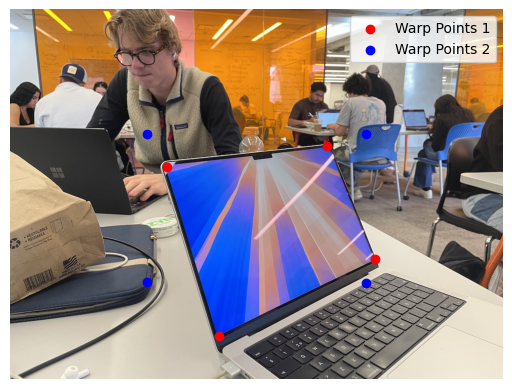

In [3]:
# Plot the image
plt.imshow(computer_screen)

# Plot the points on the image
plt.scatter(warped_points_1[:, 0], warped_points_1[:, 1], c='r', label='Warp Points 1')
plt.scatter(warped_points_2[:, 0], warped_points_2[:, 1], c='b', label='Warp Points 2')

# Add a legend
plt.legend()
plt.axis('off')
plt.show()

## Recover homography

In [4]:
# Function to compute the homography matrix
def computeH(im1_pts, im2_pts):
    num_pts = im1_pts.shape[0]

    A = []

    for i in range(num_pts):
        x1, y1 = im1_pts[i][0], im1_pts[i][1]
        x2, y2 = im2_pts[i][0], im2_pts[i][1]

        # Two rows for each correspondence (one for x', one for y')
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])

    A = np.array(A)
    _, _, V = np.linalg.svd(A)  # Perform SVD
    H = V[-1].reshape(3, 3)

    return H / H[-1, -1]  # Normalize so H[2,2] is 1

# Compute the homography matrix
H = computeH(warped_points_1, warped_points_2)
print(H)

[[ 6.24855254e-01 -1.06330322e-01  9.39511772e+01]
 [-8.88240588e-02  1.00576904e+00 -6.06668105e+01]
 [-7.74265874e-04  5.38216001e-04  1.00000000e+00]]


## Warp the Images

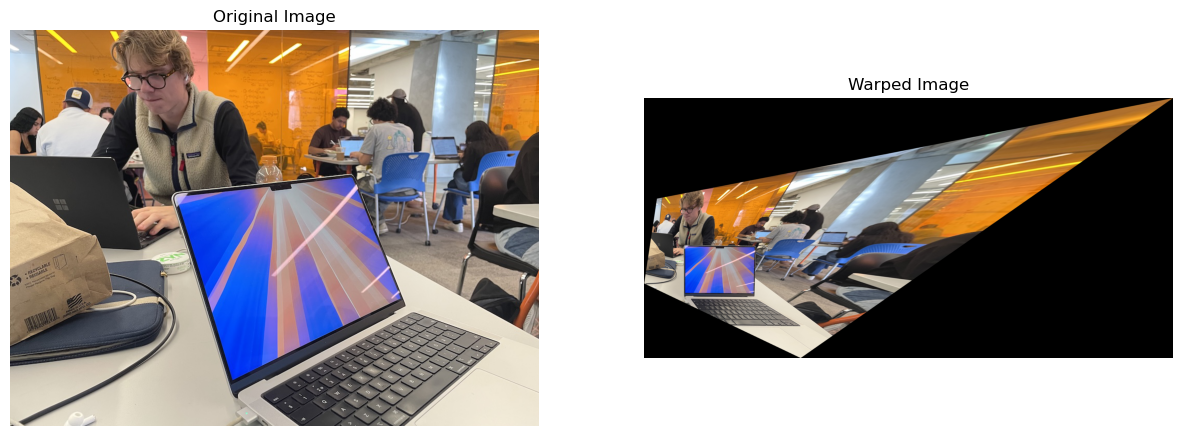

In [5]:
def warpImage(im, H):
    height, width = im.shape[:2]

    # Define corners of the original image in homogeneous coordinates
    corners = np.array([
        [0, 0, 1], [width - 1, 0, 1],
        [width - 1, height - 1, 1], [0, height - 1, 1]
    ]).T

    # Warp the corners using the homography matrix
    warped_corners = H @ corners
    warped_corners /= warped_corners[2, :]  # Normalize homogeneous coordinates

    # Calculate the bounding box for the warped image
    min_x = int(np.floor(min(warped_corners[0, :])))
    min_y = int(np.floor(min(warped_corners[1, :])))
    max_x = int(np.ceil(max(warped_corners[0, :])))
    max_y = int(np.ceil(max(warped_corners[1, :])))

    # Create a meshgrid for the output coordinates
    X, Y = np.meshgrid(np.arange(min_x, max_x), np.arange(min_y, max_y))
    warped_coords = np.vstack((X.ravel(), Y.ravel(), np.ones(X.size)))

    # Compute inverse homography to map to input image coordinates
    H_inv = np.linalg.inv(H)
    input_coords = H_inv @ warped_coords
    input_coords /= input_coords[2, :]  # Normalize homogeneous coordinates

    input_X = input_coords[0, :].reshape(max_y - min_y, max_x - min_x)
    input_Y = input_coords[1, :].reshape(max_y - min_y, max_x - min_x)

    # Interpolate pixel values for each channel
    warped_im = np.zeros((max_y - min_y, max_x - min_x, im.shape[2]), dtype=im.dtype)

    grid_x, grid_y = np.meshgrid(np.arange(width), np.arange(height))

    for channel in range(im.shape[2]):
        # interpolate using griddata
        values = im[..., channel].ravel()
        points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

        warped_im[..., channel] = sp.interpolate.griddata(
            points,
            values,
            (input_X, input_Y),
            method='linear',
            fill_value=0
        ) 

    return warped_im, min_x, min_y

# Run the function
im_warped, _, _ = warpImage(computer_screen, H)

# Display the result
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(computer_screen)
plt.title('Original Image')
plt.axis('off')

# Warped image
plt.subplot(1, 2, 2)
plt.imshow(im_warped)
plt.title('Warped Image')
plt.axis('off')

plt.show()

## Blend the Images into Mosaics

In [6]:
# Load images and points
panorama_left = plt.imread('../data/IMG_8405.jpeg')
panorama_right = plt.imread('../data/IMG_8406.jpeg')

# Load the points from the JSON file
with open('../data/berkeley.json', 'r') as f:
    points = json.load(f)

im1_points = np.array(points["im1Points"])
im2_points = np.array(points["im2Points"])

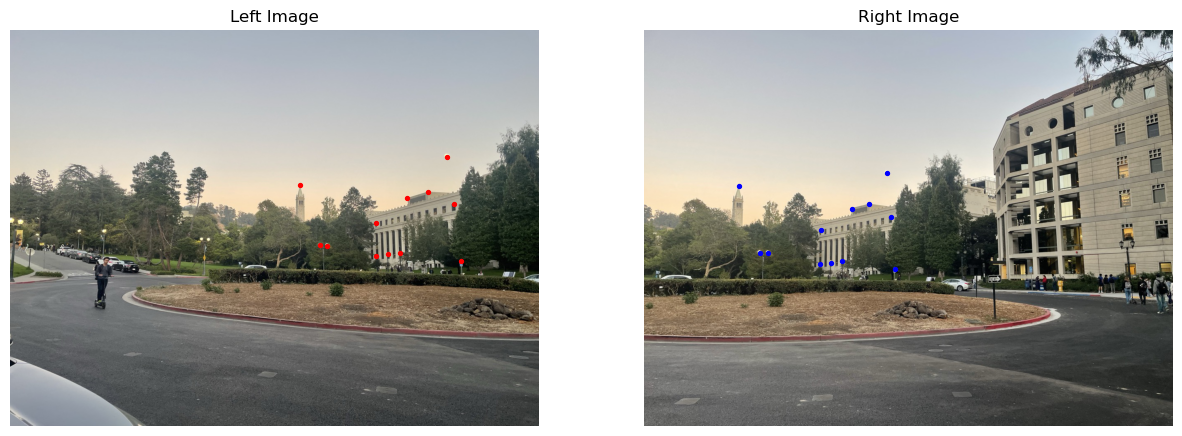

(960, 1280, 3)


In [7]:
plt.figure(figsize=(15, 10))

# Plot the left image
plt.subplot(1, 2, 1)
plt.imshow(panorama_left)
plt.scatter(im1_points[:, 0], im1_points[:, 1], c='r', s=8, label='Left Points')
plt.title('Left Image')
plt.axis('off')

# Plot the right image
plt.subplot(1, 2, 2)
plt.imshow(panorama_right)
plt.scatter(im2_points[:, 0], im2_points[:, 1], c='b', s=8, label='Right Points')
plt.title('Right Image')
plt.axis('off')

plt.show()

print(panorama_left.shape)

In [8]:
# Compute the homography matrix
H2 = computeH(im1_points, im2_points)

# Warp the right image to the left image's perspective
warped_left, min_x, min_y = warpImage(panorama_left, H2)

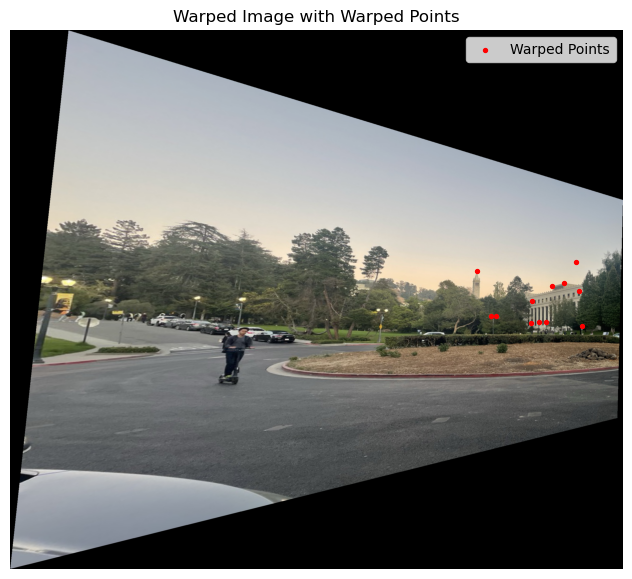

In [9]:
def warpPoints(points, H, min_x, min_y):
    # Convert points to homogeneous coordinates by adding a third column of ones
    num_points = points.shape[0]
    homogeneous_points = np.hstack([points, np.ones((num_points, 1))])

    # Apply the homography to the points
    warped_points = H @ homogeneous_points.T

    # Convert back from homogeneous coordinates to 2D
    warped_points /= warped_points[2, :]  # Normalize by the third coordinate

    # Apply the offset from the warped image's bounding box
    warped_points[0, :] -= min_x
    warped_points[1, :] -= min_y

    # Return the x, y coordinates of the warped points
    return warped_points[:2, :].T

warped_points = warpPoints(im1_points, H2, min_x, min_y)

plt.figure(figsize=(10, 7))

# Display the warped image
plt.imshow(warped_left)
plt.scatter(warped_points[:, 0], warped_points[:, 1], c='r', s=8, label='Warped Points')

# Add legend and display
plt.legend()
plt.title('Warped Image with Warped Points')
plt.axis('off')
plt.show()

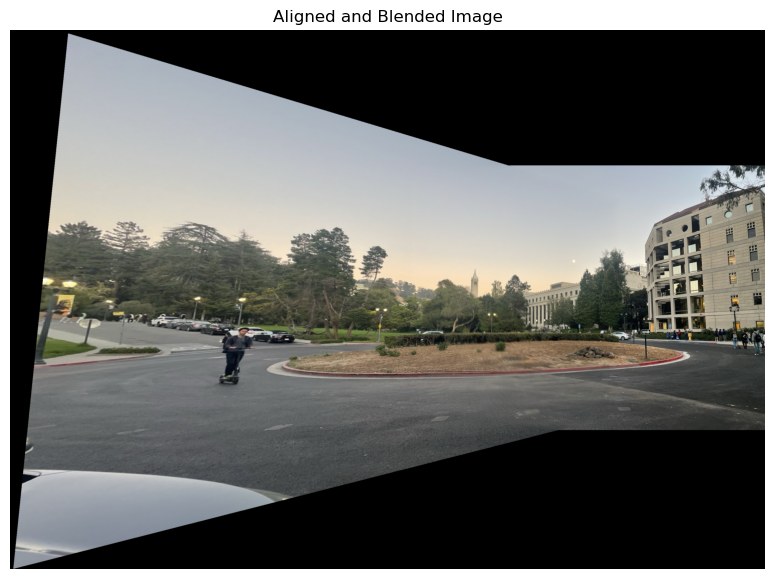

In [14]:
def create_blending_mask(warped_left, panorama_right):
    # Create binary masks for distance transform
    mask_left = np.zeros(warped_left.shape[:2], dtype=np.uint8)
    mask_right = np.zeros(panorama_right.shape[:2], dtype=np.uint8)
    
    # Left image mask: all non-black pixels are considered part of the mask
    mask_left[np.sum(warped_left, axis=2) > 0] = 1
    
    # Right image mask: all non-black pixels are considered part of the mask
    mask_right[np.sum(panorama_right, axis=2) > 0] = 1

    # Compute the distance transform
    dtrans_left = distance_transform_edt(mask_left)
    dtrans_right = distance_transform_edt(mask_right)

    # Create an alpha mask
    alpha_mask = dtrans_left / (dtrans_left + dtrans_right + 1e-10)  # Avoid division by zero
    alpha_mask = np.clip(alpha_mask, 0, 1)  # Ensure the values are between 0 and 1
    
    return alpha_mask

def blend_images(warped_left, panorama_right, alpha_mask):
    # Ensure the alpha mask has the same number of channels as the images
    alpha_mask = np.repeat(alpha_mask[:, :, np.newaxis], 3, axis=2)

    # Blend the two images using the alpha mask
    blended_image = warped_left * alpha_mask + panorama_right * (1 - alpha_mask)
    
    # Convert back to uint8 for displaying the image
    blended_image = blended_image.astype(np.uint8)
    
    return blended_image

def align_and_blend_images(im1, im2, warped_points, target_points):
    # Step 1: Compute the rotation angle
    angle_warped = np.arctan2(warped_points[1, 1] - warped_points[0, 1], 
                               warped_points[1, 0] - warped_points[0, 0])
    angle_target = np.arctan2(target_points[1, 1] - target_points[0, 1], 
                              target_points[1, 0] - target_points[0, 0])
    
    rotation_angle = angle_target - angle_warped

    # Step 2: Compute the translation
    translation_x = target_points[0, 0] - (
        np.cos(rotation_angle) * warped_points[0, 0] -
        np.sin(rotation_angle) * warped_points[0, 1]
    )
    translation_y = target_points[0, 1] - (
        np.sin(rotation_angle) * warped_points[0, 0] +
        np.cos(rotation_angle) * warped_points[0, 1]
    )

    # Step 3: Build the affine transformation matrix
    transformation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle), translation_x],
        [np.sin(rotation_angle),  np.cos(rotation_angle), translation_y]
    ])

    # Step 4: Apply the affine transformation to the warped image
    height, width = im2.shape[:2]

    # Calculate the bounding box of the transformed warped image
    corners = np.array([
        [0, 0],
        [im1.shape[1], 0],
        [im1.shape[1], im1.shape[0]],
        [0, im1.shape[0]]
    ])
    transformed_corners = cv2.transform(np.array([corners], dtype=np.float32), transformation_matrix)[0]

    min_x_transformed = min(transformed_corners[:, 0])
    max_x_transformed = max(transformed_corners[:, 0])
    min_y_transformed = min(transformed_corners[:, 1])
    max_y_transformed = max(transformed_corners[:, 1])

    # Calculate the size of the canvas
    canvas_width = int(max(max_x_transformed, width) - min(min_x_transformed, 0))
    canvas_height = int(max(max_y_transformed, height) - min(min_y_transformed, 0))

    # Step 5: Overlay the aligned image over im2
    result_image = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    offset_x = int(-min(min_x_transformed, 0))
    offset_y = int(-min(min_y_transformed, 0))
    result_image[offset_y:offset_y + height, offset_x:offset_x + width] = im2  # Add the base image

    # Adjust the translation for the warped image to be centered
    translation_x_centered = translation_x + offset_x
    translation_y_centered = translation_y + offset_y

    # Update the transformation matrix with the centered translation
    transformation_matrix_centered = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle), translation_x_centered],
        [np.sin(rotation_angle),  np.cos(rotation_angle), translation_y_centered]
    ])

    # Apply the centered affine transformation to the warped image
    aligned_image_centered = cv2.warpAffine(im1, transformation_matrix_centered, (canvas_width, canvas_height))

    # Step 6: Create the blending mask using the aligned images
    alpha_mask = create_blending_mask(aligned_image_centered, result_image)

    # Step 7: Blend the images using the generated alpha mask
    blended_image = blend_images(aligned_image_centered, result_image, alpha_mask)

    return blended_image

# Align and blend the images
result_image = align_and_blend_images(warped_left, panorama_right, warped_points, im2_points)

# Display the result
plt.figure(figsize=(10, 7))
plt.imshow(result_image)
plt.title('Aligned and Blended Image')
plt.axis('off')
plt.show()